# Support Vector Regressor 
## Demand Prediction 

4. Predictive Analytics with Support Vector Machines:

Develop two prediction models that predict a) bike rental demand and b) bike availability in spatio-temporal resolution. 
In other words, your method should predict for each hexagon and time-basket (e.g., 08am-11.59am) the bike demand and number of available vehicles.

– Simply start without a kernel. Then, gradually make your model complex by integrating different
kind of kernels. Also, use grid search to find optimal values for your hyperparameters.

– How good is your model? Evaluate your model’s performance and comment on its shortfalls.

– Show how you model’s performance varies as you increase or decrease temporal resolution for the
following period length:1h, 2h, 6h, 24h. Also, vary the length of the hexagon edges.

– How could the model be improved further? Explain some of the improvement levers that you might
focus on in a follow-up project.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
import geopandas
import json
from shapely.geometry import shape
from h3 import h3
from vincenty import vincenty 
warnings.filterwarnings("ignore")

In [2]:
# read in transformed trip data 
bonn_trips = pd.read_csv("Data/bonn_trips.csv", index_col=0)

# drop columns that were created in Data Preparation / new hexagon resolutions will be created below 
bonn_trips.drop(["h3_hex_id", "geometry"],axis=1, inplace =True) 

bonn_trips.head()

,index_start,p_place_type_start,datetime_start,b_number_start,trip_start,p_uid_start,p_bikes_x,latitude_start,longitude_start,p_name_start,...,weekend,day,month,hour,minute,temperature °C,relative_humidity,precipitaion_level (mm),precipitation y/n,average_wind_speed (m/s)
0,3,12,2019-01-20 03:20:00,44952,start,12040694,1,50.703284,7.154586,BIKE 44952,...,True,20,1,3,20,-5.6,86.0,0.0,0,2.4
1,25,12,2019-01-20 03:08:00,44931,start,12093216,1,50.747953,7.119311,BIKE 44931,...,True,20,1,3,8,-5.6,86.0,0.0,0,2.4
2,75,0,2019-01-20 03:06:00,44594,start,10044445,2,50.736217,7.094604,Alter Friedhof,...,True,20,1,3,6,-5.6,86.0,0.0,0,2.4
3,177,12,2019-01-20 03:52:00,44966,start,12069877,1,50.708533,7.105807,BIKE 44966,...,True,20,1,3,52,-5.6,86.0,0.0,0,2.4
4,409,12,2019-01-20 03:30:00,44637,start,12098186,1,50.732503,7.097200,BIKE 44637,...,True,20,1,3,30,-5.6,86.0,0.0,0,2.4


In [3]:
# set new hex resolution for the prediction 
# therefore the start coordinates of one trip is used 
H3_HEXAGON_RESOLUTION = 7
bonn_trips["h3_hex_id"] = bonn_trips.apply(lambda row: h3.geo_to_h3(row["latitude_start"], row["longitude_start"], H3_HEXAGON_RESOLUTION) if (row['latitude_start'] and row['longitude_start']) else 0, axis=1)

In [4]:
# calculate the centers of the hexagons to use this information for further Support Verctor Regressions 
def centroid(h3hexId):
    vertexes = h3.h3_to_geo_boundary(h3hexId)
    _x_list = [vertex [0] for vertex in vertexes]
    _y_list = [vertex [1] for vertex in vertexes]
    _len = len(vertexes)
    _x = sum(_x_list) / _len
    _y = sum(_y_list) / _len
    return _x, _y

bonn_trips["center"] = bonn_trips["h3_hex_id"].apply(lambda x: centroid(x))
bonn_trips["center_x"] = bonn_trips["center"].apply(lambda x: x[0])
bonn_trips["center_y"]  = bonn_trips["center"].apply(lambda x: x[1])

In [5]:
# returns a time basket 
def get_timebasket(hour):
    #from 5.00 to 10.59 : Morning
    if hour>4 and hour<11:
        x=0
        return x
    #from 11.00 to 12.59 : noon
    if hour>10 and hour<13:
        x=1
        return x
    #from 13.00 to 17.59 : afternoon
    if hour>12 and hour<18:
        x=2
        return x
    #from 18.00 to 22.59 : evening
    if hour>17 and hour<23:
        x=3
        return x
    #from 23.00 to 4.59 : night
    if (hour>22 and hour<25)or hour<5:
        x=4
        return x


In [6]:
bonn_trips['time_basket'] = bonn_trips['hour'].apply(lambda x: get_timebasket(x))

In [7]:
bonn_trips.head(10)

,index_start,p_place_type_start,datetime_start,b_number_start,trip_start,p_uid_start,p_bikes_x,latitude_start,longitude_start,p_name_start,...,temperature °C,relative_humidity,precipitaion_level (mm),precipitation y/n,average_wind_speed (m/s),h3_hex_id,center,center_x,center_y,time_basket
0,3,12,2019-01-20 03:20:00,44952,start,12040694,1,50.703284,7.154586,BIKE 44952,...,-5.6,86.0,0.0,0,2.4,871fa11adffffff,"(50.7007021326335, 7.156033620241504)",50.700702,7.156034,4
1,25,12,2019-01-20 03:08:00,44931,start,12093216,1,50.747953,7.119311,BIKE 44931,...,-5.6,86.0,0.0,0,2.4,871fa1115ffffff,"(50.75059224558738, 7.131094546754574)",50.750592,7.131095,4
2,75,0,2019-01-20 03:06:00,44594,start,10044445,2,50.736217,7.094604,Alter Friedhof,...,-5.6,86.0,0.0,0,2.4,871fa1116ffffff,"(50.72749974896255, 7.084087708228729)",50.727500,7.084088,4
3,177,12,2019-01-20 03:52:00,44966,start,12069877,1,50.708533,7.105807,BIKE 44966,...,-5.6,86.0,0.0,0,2.4,871fa1112ffffff,"(50.71216923030724, 7.103470962413081)",50.712169,7.103471,4
4,409,12,2019-01-20 03:30:00,44637,start,12098186,1,50.732503,7.097200,BIKE 44637,...,-5.6,86.0,0.0,0,2.4,871fa1116ffffff,"(50.72749974896255, 7.084087708228729)",50.727500,7.084088,4
5,559,12,2019-01-20 03:26:00,44642,start,12099429,1,50.728528,7.076081,BIKE 44642,...,-5.6,86.0,0.0,0,2.4,871fa1116ffffff,"(50.72749974896255, 7.084087708228729)",50.727500,7.084088,4
6,899,12,2019-01-20 03:11:00,44953,start,12097991,1,50.742164,7.066421,BIKE 44953,...,-5.6,86.0,0.0,0,2.4,871fa1c49ffffff,"(50.74282204249567, 7.0646981080534585)",50.742822,7.064698,4
7,945,12,2019-01-20 03:50:00,44597,start,12097572,1,50.739404,7.117717,BIKE 44597,...,-5.6,86.0,0.0,0,2.4,871fa1110ffffff,"(50.73138332080408, 7.117278360514686)",50.731383,7.117278,4
8,985,12,2019-01-20 03:26:00,44936,start,12097106,1,50.744732,7.095918,BIKE 44936,...,-5.6,86.0,0.0,0,2.4,871fa1114ffffff,"(50.746711578797594, 7.097891199341479)",50.746712,7.097891,4
9,1433,12,2019-01-20 03:32:00,44720,start,12100574,1,50.733480,7.098862,BIKE 44720,...,-5.6,86.0,0.0,0,2.4,871fa1116ffffff,"(50.72749974896255, 7.084087708228729)",50.727500,7.084088,4


In [9]:
# grouped dataframe by following feature - 
# sums up the number of trips for each hex, month, day, timebasket 
grouped_trips = pd.DataFrame(bonn_trips.groupby(['h3_hex_id','month', 'day',"time_basket", "weekend", "weekday","center_x","center_y"], as_index = False).size())
grouped_trips.rename({0:"Demand"},axis=1, inplace=True )
grouped_trips.reset_index(inplace=True)
grouped_trips.head()

,h3_hex_id,month,day,time_basket,weekend,weekday,center_x,center_y,Demand
0,871fa1010ffffff,4,21,2,True,6,50.623855,7.252811,1
1,871fa1010ffffff,5,24,1,False,4,50.623855,7.252811,2
2,871fa1010ffffff,12,23,3,False,0,50.623855,7.252811,2
3,871fa1010ffffff,12,25,2,False,2,50.623855,7.252811,2
4,871fa1010ffffff,12,26,3,False,3,50.623855,7.252811,2


In [12]:
# grouped dataframe to calculate the mean of the temperatur per day and timebasket 
grouped_weather = pd.DataFrame(bonn_trips.groupby(['time_basket', 'h3_hex_id', 'month', 'day'], as_index = False).mean())
grouped_weather.reset_index(inplace=True)
grouped_weather = grouped_weather[['time_basket', 'h3_hex_id', 'month', 'day',"temperature °C","precipitaion_level (mm)"]]
grouped_weather.head()

,time_basket,h3_hex_id,month,day,temperature °C,precipitaion_level (mm)
0,0,871fa1010ffffff,12,28,0.1,0.0
1,0,871fa1014ffffff,4,11,3.9,0.0
2,0,871fa1014ffffff,4,16,13.6,0.0
3,0,871fa1014ffffff,5,31,20.5,0.0
4,0,871fa1014ffffff,6,9,17.7,0.0


In [12]:
#grouped_rain_bool = pd.DataFrame(df_bonn_trips.groupby(['time_basket', 'h3_hex_id', 'month', 'day'], as_index = False).max())
# grouped_rain_bool.reset_index(inplace=True)
# grouped_rain_bool = grouped_rain_bool[['time_basket', 'h3_hex_id', 'month', 'day',"precipitation y/n"]]
# grouped_rain_bool

In [13]:
# merge mean temperature with the demands 
df_demand = grouped_trips.merge(grouped_weather, on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")
df_demand["weekend"] = df_demand["weekend"].apply(lambda x : 1 if x else 0)
df_demand

,h3_hex_id,month,day,time_basket,weekend,weekday,center_x,center_y,Demand,temperature °C,precipitaion_level (mm)
0,871fa1010ffffff,4,21,2,1,6,50.623855,7.252811,1,23.000000,0.0
1,871fa1010ffffff,5,24,1,0,4,50.623855,7.252811,2,22.300000,0.0
2,871fa1010ffffff,12,23,3,0,0,50.623855,7.252811,2,6.400000,0.0
3,871fa1010ffffff,12,25,2,0,2,50.623855,7.252811,2,6.400000,0.1
4,871fa1010ffffff,12,26,3,0,3,50.623855,7.252811,2,5.200000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
43010,871fa1ccdffffff,9,6,4,0,4,50.623541,6.948978,1,8.400000,0.0
43011,871fa1ce6ffffff,2,24,2,1,6,50.657628,6.791556,3,12.966667,0.0
43012,871fa1ce9ffffff,6,21,2,0,4,50.658104,6.943334,1,20.900000,0.0
43013,871fa1d44ffffff,9,27,0,0,4,50.868469,6.790325,1,13.600000,0.0


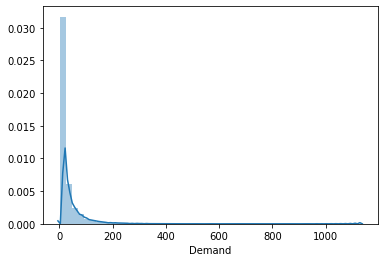

In [15]:
sns.distplot(df_demand["Demand"])

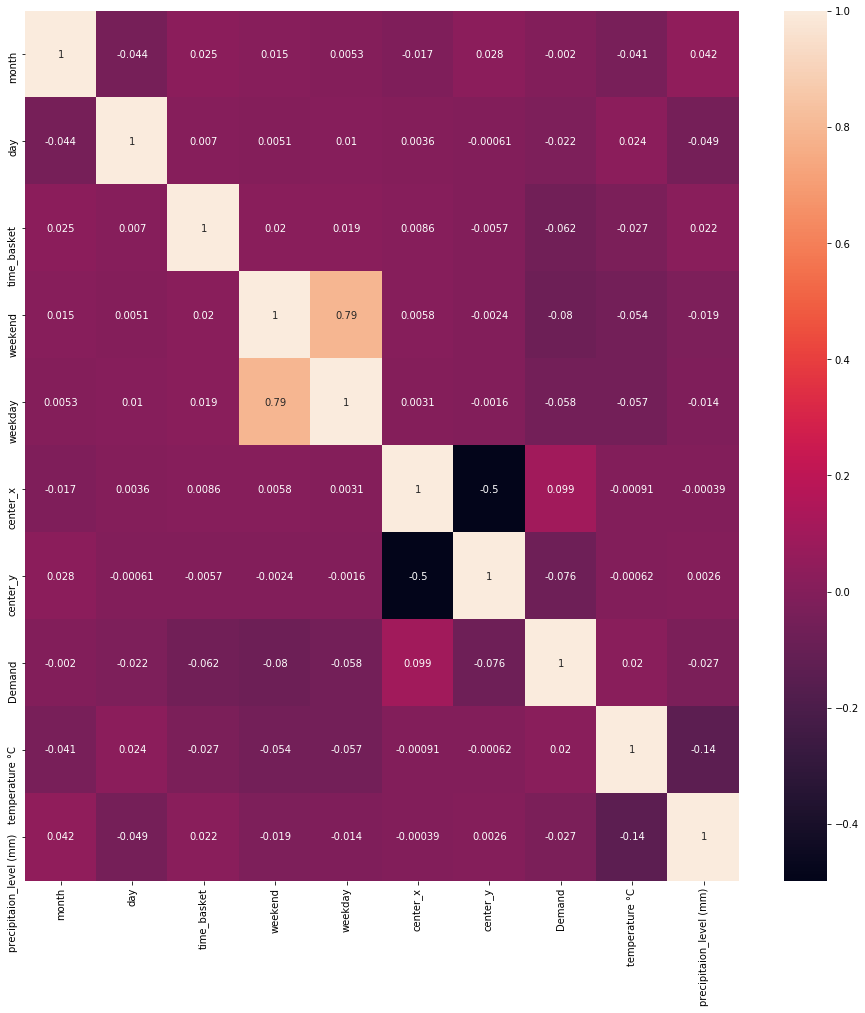

In [16]:
# get a feeling of correlations between the Demand and the other features 
plt.figure(figsize=(16, 16))
sns.heatmap(df_demand.corr(), annot=True)
plt.show()

In [17]:
df_demand.describe()
# --> min temperature doesn't make sense 
# handled this incorrect values below 

,month,day,time_basket,weekend,weekday,center_x,center_y,Demand,temperature °C,precipitaion_level (mm)
count,43015.000000,43015.000000,43015.000000,43015.000000,43015.000000,43015.000000,43015.000000,43015.000000,43015.000000,43015.000000
mean,7.027223,16.011763,1.947576,0.286040,2.996652,50.718306,7.118848,24.394118,8.695019,0.071487
std,3.103562,8.845255,1.389426,0.451913,2.004885,0.033996,0.052412,42.412523,65.694568,0.335808
min,1.000000,1.000000,0.000000,0.000000,0.000000,50.364774,6.790325,1.000000,-999.000000,0.000000
25%,5.000000,8.000000,1.000000,0.000000,1.000000,50.696830,7.078498,3.000000,7.500000,0.000000
50%,7.000000,16.000000,2.000000,0.000000,3.000000,50.719916,7.122848,9.000000,12.900000,0.000000
75%,10.000000,24.000000,3.000000,1.000000,5.000000,50.742822,7.161583,27.000000,18.000000,0.000000
max,12.000000,31.000000,4.000000,1.000000,6.000000,50.961378,7.651676,1131.000000,39.400000,14.400000


In [18]:
# fill incorrect values with mean values of the corresponding month
temp_means = df_demand.groupby(["month"]).mean()[["temperature °C"]]
for i, row in df_demand.iterrows(): 
    if row["temperature °C"] < -40: # probably incorrect values 
        df_demand.at[i, "temperature °C"] = temp_means.iloc[row["month"]]        

In [19]:
df_demand.describe()

,month,day,time_basket,weekend,weekday,center_x,center_y,Demand,temperature °C,precipitaion_level (mm)
count,43015.000000,43015.000000,43015.000000,43015.000000,43015.000000,43015.000000,43015.000000,43015.000000,43015.000000,43015.000000
mean,7.027223,16.011763,1.947576,0.286040,2.996652,50.718306,7.118848,24.394118,13.125001,0.071487
std,3.103562,8.845255,1.389426,0.451913,2.004885,0.033996,0.052412,42.412523,7.381485,0.335808
min,1.000000,1.000000,0.000000,0.000000,0.000000,50.364774,6.790325,1.000000,-34.743548,0.000000
25%,5.000000,8.000000,1.000000,0.000000,1.000000,50.696830,7.078498,3.000000,7.531667,0.000000
50%,7.000000,16.000000,2.000000,0.000000,3.000000,50.719916,7.122848,9.000000,12.900000,0.000000
75%,10.000000,24.000000,3.000000,1.000000,5.000000,50.742822,7.161583,27.000000,18.000000,0.000000
max,12.000000,31.000000,4.000000,1.000000,6.000000,50.961378,7.651676,1131.000000,39.400000,14.400000


In [20]:
df_demand.head()

,h3_hex_id,month,day,time_basket,weekend,weekday,center_x,center_y,Demand,temperature °C,precipitaion_level (mm)
0,871fa1010ffffff,4,21,2,1,6,50.623855,7.252811,1,23.0,0.0
1,871fa1010ffffff,5,24,1,0,4,50.623855,7.252811,2,22.3,0.0
2,871fa1010ffffff,12,23,3,0,0,50.623855,7.252811,2,6.4,0.0
3,871fa1010ffffff,12,25,2,0,2,50.623855,7.252811,2,6.4,0.1
4,871fa1010ffffff,12,26,3,0,3,50.623855,7.252811,2,5.2,0.0


In [22]:
# create new feature for better prediction results 
df_demand["distanceToCentralStation"] = df_demand[["center_x","center_y"]].apply(
    lambda x: vincenty([x[0], x[1]], [50.731944, 7.096944]), axis=1)

In [23]:
X = df_demand[["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C","distanceToCentralStation"]]
y = df_demand[["Demand"]]

from sklearn.preprocessing import StandardScaler
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)
scaler = StandardScaler()

svr = SVR()
svr.fit(scaler.fit_transform(X_train), y_train)
y_pred = svr.predict(scaler.fit_transform(X_test))

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('\n','R2: ', r2, '\n','Mean absolute error: ', mae,'\n','Mean squared error: ', mse )


 R2:  0.29653954073465283 
 Mean absolute error:  15.522875003781218 
 Mean squared error:  1285.1891313831545
